In [373]:
from typing import TypedDict, Tuple
from os import makedirs, path
from shutil import rmtree

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [374]:
columns_file = "./columns.txt"

# Funções Utilitárias

In [375]:
def read_columns_txt(path: str) -> list:
    return open(path, "r").read().splitlines()

In [376]:
columns = read_columns_txt(columns_file)

In [377]:
def get_vcdb(columns: list) -> pd.DataFrame:
    return pd.read_csv(
            "./data/vcdb.csv",
            low_memory=False,
            usecols=columns
            )

In [378]:
def count_categories(pattern: str, return_last_category: bool = True) -> pd.DataFrame:
    columns = read_columns_txt(columns_file)

    # Interpreta o pattern
    pattern_parts = pattern.split(".")

    def match(col: str) -> bool:
        col_parts = col.split(".")
        if len(col_parts) < len(pattern_parts):
            return False
        return all(p == "*" or p == c for p, c in zip(pattern_parts, col_parts))

    # Filtra colunas com base no padrão
    filtered_columns = [col for col in columns if match(col)]

    raw_dataframe = get_vcdb(filtered_columns).select_dtypes(include='bool')
    df = raw_dataframe.sum().sort_values(ascending=False).reset_index()
    df.columns = ["category", "occurrences"]

    if return_last_category:
        df["category"] = df["category"].apply(lambda x: x.split(".")[-1])

    return df

In [379]:
rmtree("./img/")

if not path.exists("img"):
    makedirs("img")

In [380]:
class PlotMetadata(TypedDict):
    title: str
    xlabel: str
    ylabel: str
    xrotation: int
    figsize: Tuple[int, int]


def barplot(fig_name: str, data: pd.Series, plot: PlotMetadata, show: bool = False) -> None:
    # Cria figura e eixo
    fig, ax = plt.subplots(figsize=plot.get("figsize") or (14, 8))

    # Plota os dados e armazena o objeto de barras
    bars = ax.bar(data.index, data.values, color="#4C72B0", edgecolor="black")

    # Adiciona título e labels
    ax.set_title(plot.get("title"), fontsize=14, fontweight="bold", pad=25)
    ax.set_xlabel(plot.get("xlabel"), fontsize=14)
    ax.set_ylabel(plot.get("ylabel"), fontsize=14)

    # Adiciona os valores nas barras
    ax.bar_label(bars, fontsize=12, padding=5, fmt="%d")

    # Limpa bordas
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Grelha horizontal leve
    ax.yaxis.grid(True, linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    
    # Rotação dos rótulos do eixo X
    plt.xticks(rotation=plot["xrotation"], ha="center")

    # Layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if show:
        fig.show()

    plt.savefig(f"img/{fig_name}.png", dpi=1000)


# Ações
* 1. Ambiental
* 2. Erro
* 3. Físico
* 4. Hacking
* 5. Malware
* 6. Social
* 7. Uso Incorreto

## Incidentes por tipo de ação

In [492]:
count_categories("action.*.variety.*", return_last_category=False)

,category,occurrences
0,action.hacking.variety.Unknown,1828
1,action.misuse.variety.Privilege abuse,1230
2,action.physical.variety.Theft,1195
3,action.malware.variety.Ransomware,1171
4,action.hacking.variety.Exploit vuln,1048
...,...,...
173,action.malware.variety.Profile host,0
174,action.malware.variety.Pass-the-hash,0
175,action.malware.variety.Modify data,0
176,action.physical.variety.Evade Defenses,0


In [ ]:
df = count_categories("action.*.variety.*", return_last_category=False)
df["category"] = df["category"].apply(lambda x: x.split(".")[1])

replace_map = {
    "hacking": "Hacking",
    "malware": "Malware",
    "error": "Erro",
    "misuse": "Uso indevido",
    "physical": "Físico",
    "social": "Social",
    "unknown": "Desconhecido",
    "environmental": "Ambiental"
}

data = (df
        .groupby("category")
        .sum()
        .sort_values(ascending=False, by="occurrences")
        .reset_index()
        .replace(replace_map)
        .set_index("category")
        ["occurrences"]
        .sort_values(ascending=False)
    )

barplot(
    fig_name="incidents_by_action",
    data=data,
    plot={
        "title": f"Incidentes por tipo de Action (n = {data.sum()})",
        "xlabel": "Tipo",
        "ylabel": "Ocorrências",
        "xrotation": 45,
        "figsize": (12,8)
    }
)

category
Malware         4848
Hacking         4617
Erro            2800
Uso indevido    2119
Físico          2112
Social           696
Ambiental         10
Name: occurrences, dtype: int64

## Ambiental

### Variedades

In [382]:
count_categories(pattern="action.environmental.variety.*").head(10)

,category,occurrences
0,Unknown,4
1,Power failure,2
2,Fire,2
3,Humidity,1
4,Hurricane,1
5,ESD,0
6,EMI,0
7,Deterioration,0
8,Earthquake,0
9,Flood,0


## Errors

### Variedades

In [383]:
count_categories(pattern="action.error.variety").head(10)

,category,occurrences
0,Misdelivery,977
1,Loss,420
2,Publishing error,412
3,Misconfiguration,369
4,Disposal error,329
5,Other,77
6,Programming error,67
7,Unknown,50
8,Gaffe,41
9,Malfunction,34


## Físico

### Variedades

In [384]:
count_categories(pattern="action.physical.variety").head(10)

,category,occurrences
0,Theft,1195
1,Disabled controls,280
2,Tampering,259
3,Skimmer,199
4,Bypassed controls,64
5,Surveillance,56
6,Assault,30
7,Snooping,12
8,Unknown,6
9,Connection,3


## Hacking

### Variedades

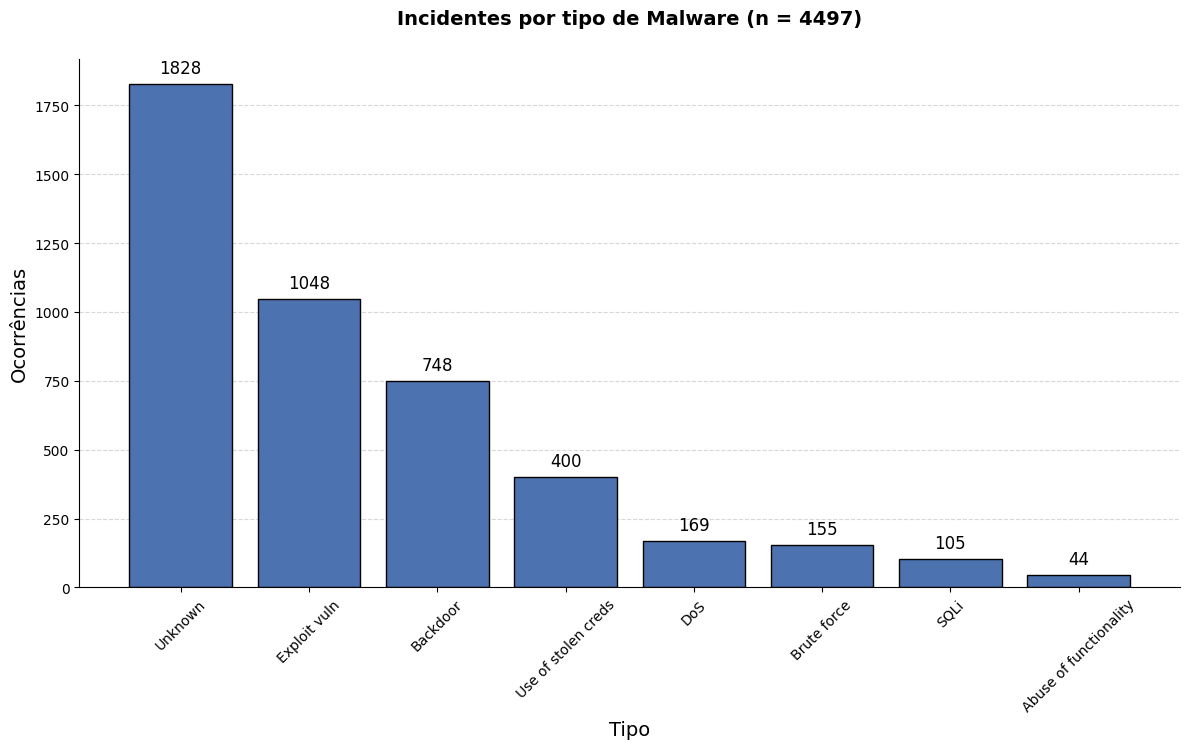

In [498]:
df = count_categories(pattern="action.hacking.variety.*", return_last_category=True)[:8]

data = (df
        .groupby("category")
        .sum()
        .sort_values(ascending=False, by="occurrences")
        .reset_index()
        .set_index("category")
        ["occurrences"]
        .sort_values(ascending=False)
    )

barplot(
    fig_name="hacking_types",
    data=data,
    plot={
        "title": f"Incidentes por tipo de Malware (n = {data.sum()})",
        "xlabel": "Tipo",
        "ylabel": "Ocorrências",
        "xrotation": 45,
        "figsize": (12,8)
    }
)

,category,occurrences
0,Unknown,1828
1,Exploit vuln,1048
2,Backdoor,748
3,Use of stolen creds,400
4,DoS,169
5,Brute force,155
6,SQLi,105
7,Abuse of functionality,44
8,Other,42
9,Forced browsing,19


## Malwares

### Variedades

In [386]:
count_categories(pattern="action.malware.variety").head(10)

,category,occurrences
0,Ransomware,1171
1,Backdoor or C2,1015
2,Backdoor,992
3,C2,204
4,Capture stored data,189
5,Downloader,178
6,Unknown,174
7,Spyware/Keylogger,149
8,Export data,127
9,Scan network,106


## Social

### Variedades

In [387]:
count_categories(pattern="action.social.variety").head(10)

,category,occurrences
0,Phishing,448
1,Pretexting,69
2,Bribery,60
3,Extortion,44
4,Forgery,18
5,Unknown,17
6,Influence,16
7,Other,11
8,Scam,3
9,Propaganda,3


## Uso Incorreto

### Variedades

In [388]:
count_categories(pattern="action.misuse.variety").head(10)

,category,occurrences
0,Privilege abuse,1230
1,Possession abuse,250
2,Data mishandling,235
3,Knowledge abuse,197
4,Unapproved hardware,62
5,Unknown,48
6,Email misuse,31
7,Net misuse,20
8,Unapproved workaround,16
9,Unapproved software,9


# Atores

## Interno

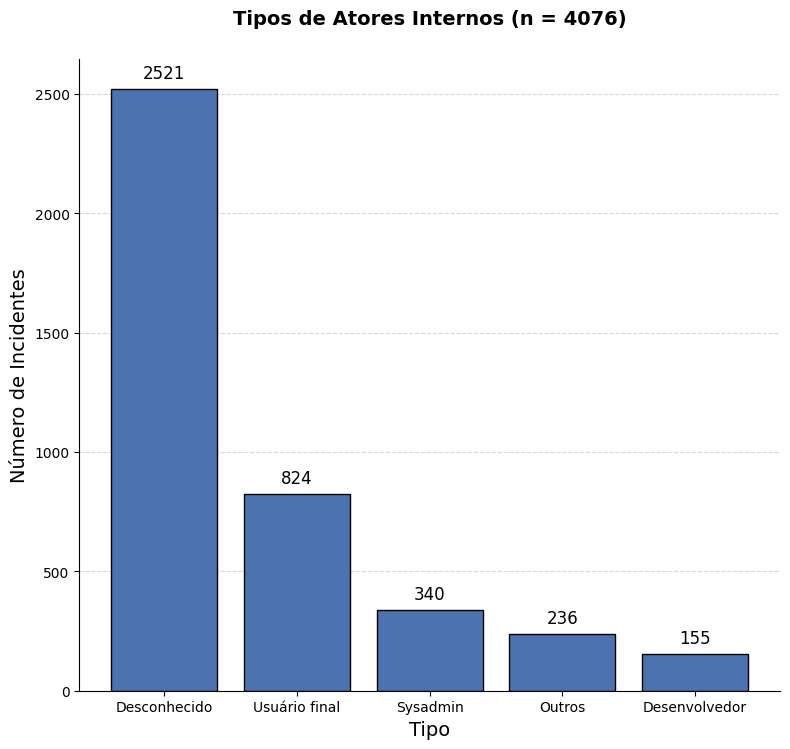

In [389]:
internal_actors = count_categories(pattern="actor.internal.variety.*", return_last_category=True)

translate_map = {
    "Unknown": "Desconhecido",
    "End-user": "Usuário final",
    "System admin": "Sysadmin",
    "Other": "Outros",
    "Developer": "Desenvolvedor"
}

data = internal_actors.replace(translate_map).set_index("category")["occurrences"].sort_values(ascending=False)[:5]
data

barplot(
    fig_name="internal_actors_type",
    data=data,
    plot={
        "title": f"Tipos de Atores Internos (n = {data.sum()})",
        "xlabel": "Tipo",
        "ylabel": "Número de Incidentes",
        "xrotation": 0,
        "figsize": (8,8)
    }
)

## Externo

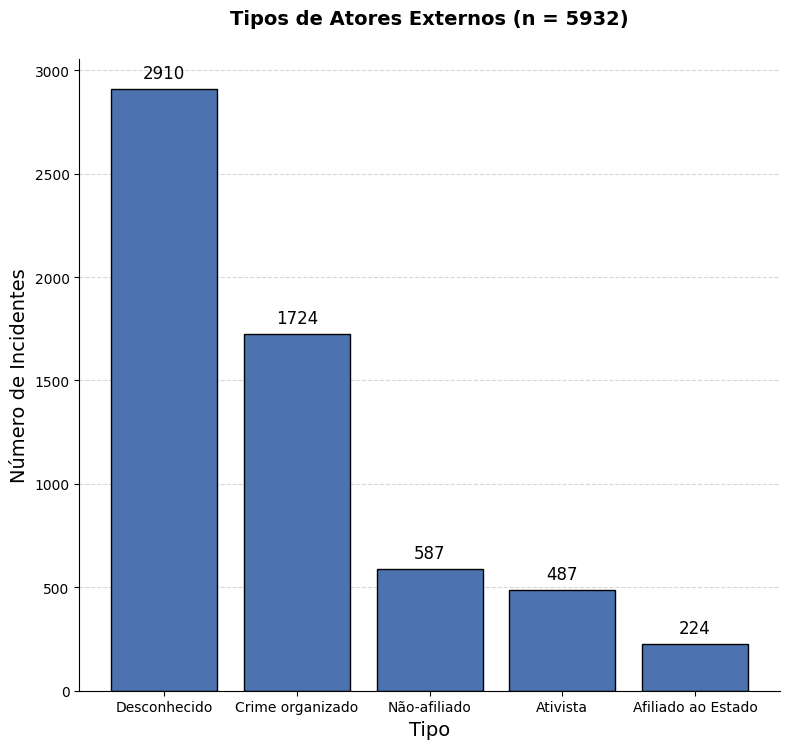

In [390]:
external_actors = count_categories(pattern="actor.external.variety.*", return_last_category=True)

translate_map = {
    "Unknown": "Desconhecido",
    "Organized crime": "Crime organizado",
    "Unaffiliated": "Não-afiliado",
    "Activist": "Ativista",
    "State-affiliated": "Afiliado ao Estado"
}

data = external_actors.replace(translate_map).set_index("category")["occurrences"].sort_values(ascending=False)[:5]
data

barplot(
    fig_name="external_actors_type",
    data=data,
    plot={
        "title": f"Tipos de Atores Externos (n = {data.sum()})",
        "xlabel": "Tipo",
        "ylabel": "Número de Incidentes",
        "xrotation": 0,
        "figsize": (8,8)
    }
)

# Descoberta

In [391]:
# 1. Seleciona colunas de ação do tipo "variety"
action_variety_cols = [col for col in columns if col.startswith("action.") and ".variety." in col]
base_actions_df = get_vcdb(columns)

# 2. Derrete o DataFrame: mantém apenas valores True
df_melted = base_actions_df[action_variety_cols].copy()
df_long = df_melted[df_melted == True].stack().reset_index()
df_long.columns = ["row", "col", "value"]

# 3. Extrai "tipo" (nível 2) e "ataque" (último nível)
df_long["tipo"] = df_long["col"].apply(lambda x: x.split(".")[1])       # e.g. 'hacking'
df_long["ataque"] = df_long["col"].apply(lambda x: x.split(".")[-1])   # e.g. 'DoS'

# 4. Cria DataFrame com tempo de descoberta
unit_columns = [
    "timeline.discovery.unit.Days",
    "timeline.discovery.unit.Hours",
    "timeline.discovery.unit.Minutes",
    "timeline.discovery.unit.Months",
    "timeline.discovery.unit.NA",
    "timeline.discovery.unit.Never",
    "timeline.discovery.unit.Seconds",
    "timeline.discovery.unit.Unknown",
    "timeline.discovery.unit.Weeks",
    "timeline.discovery.unit.Years",
]

df_time = base_actions_df[["timeline.discovery.value"] + unit_columns].copy()
df_time["unit"] = df_time[unit_columns].idxmax(axis=1).apply(lambda x: x.split(".")[-1].lower())

# Mapa de conversão de unidade para dias
unit_to_days = {
    "seconds": 1 / 86400,
    "minutes": 1 / 1440,
    "hours": 1 / 24,
    "days": 1,
    "weeks": 7,
    "months": 30,
    "years": 365,
    "na": None,
    "never": None,
    "unknown": None
}

def convert_to_days(row):
    unit = row["unit"]
    value = row["timeline.discovery.value"]
    factor = unit_to_days.get(unit)
    if factor is None or pd.isna(value):
        return None
    return value * factor

df_time["discovery_days"] = df_time.apply(convert_to_days, axis=1)

# 5. Junta tudo no DataFrame final
discovery_by_action = df_long.merge(df_time[["discovery_days"]], left_on="row", right_index=True, how="left")

# 6. Remove entradas sem tempo válido
discovery_by_action = discovery_by_action[discovery_by_action["discovery_days"].notnull()].copy()[["tipo", "ataque", "discovery_days"]]
discovery_by_action.head()

,tipo,ataque,discovery_days
10,physical,Theft,60.0
22,error,Gaffe,2.0
24,error,Disposal error,150.0
49,physical,Theft,150.0
62,hacking,Unknown,30.0


## Tempo Médio Geral

In [392]:
valores = discovery_by_action["discovery_days"]

# Defina os limites dos bins
bins = [0, 10, 50, 100, 250, 500, 750, 1000, float('inf')]  # última faixa pega tudo acima de 1000

# Crie os rótulos
labels = ["0-10", "11-50", "51-100", "101-250", "251-500", "501-750", "751-1000", "1000+"]

# Aplique o binning
valores_binned = pd.cut(valores, bins=bins, labels=labels, right=True)

# Resultado
bins_df = pd.DataFrame({"valor": valores, "faixa": valores_binned})

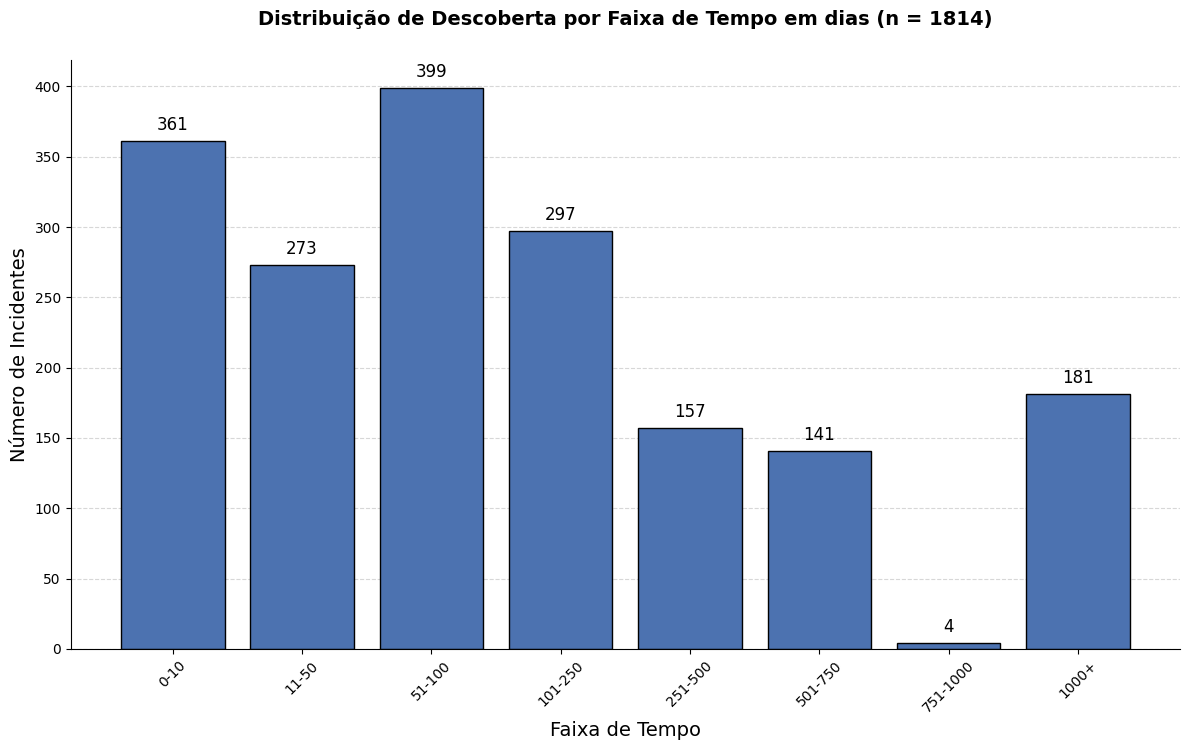

In [393]:
plot_data = bins_df["faixa"].value_counts().sort_index()

barplot(
    fig_name="discovery_time",
    data=plot_data,
    plot={
        "title": f"Distribuição de Descoberta por Faixa de Tempo em dias (n = {bins_df.shape[0]})",
        "xlabel": "Faixa de Tempo",
        "ylabel": "Número de Incidentes",
        "xrotation": 45,
        "figsize": (12,8)
    }
)


## Tempo Médio por Tipo

In [477]:
mean_discovery_by_tipo = discovery_by_action.groupby("tipo")["discovery_days"].mean()
mean_discovery_by_tipo = mean_discovery_by_tipo.rename_axis('tipo')  # garante nome do índice
mean_discovery_by_tipo = mean_discovery_by_tipo.to_frame()
mean_discovery_by_tipo

,discovery_days
tipo,
environmental,0.000012
error,326.043598
hacking,195.119148
malware,209.899066
misuse,873.114865
physical,104.481065
social,267.595794


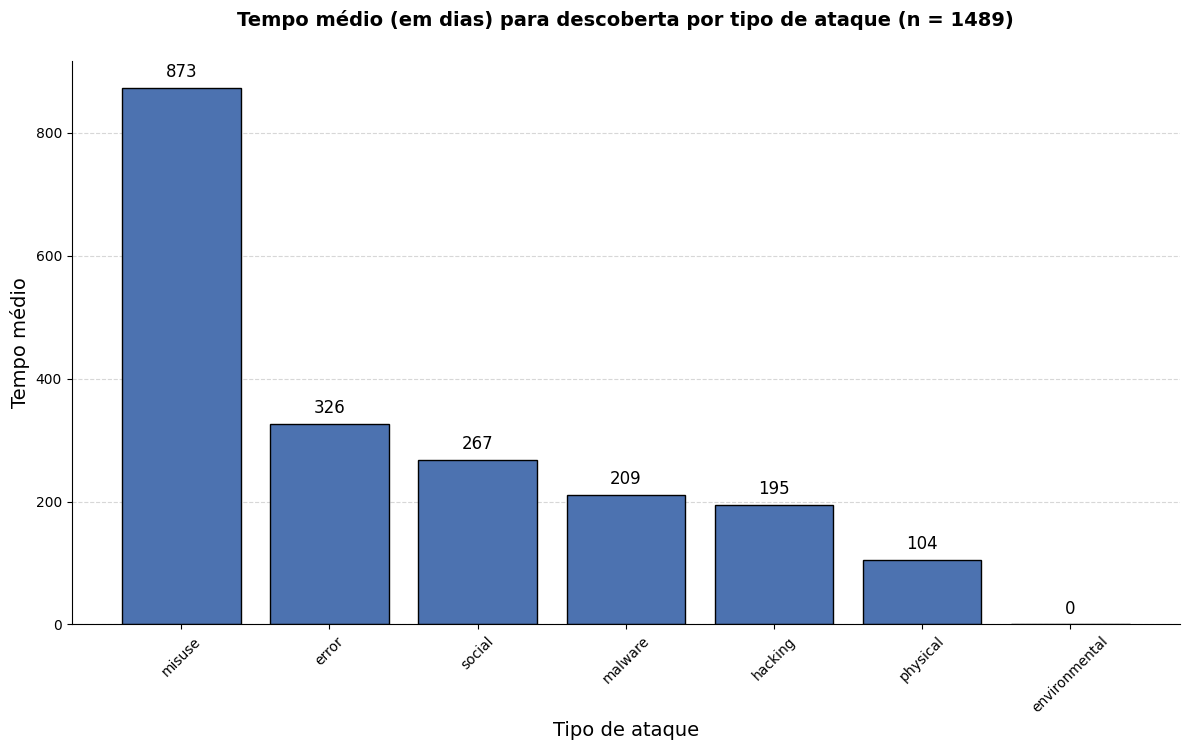

In [395]:
avg_time_by_type = discovery_by_action.groupby("tipo")["discovery_days"].mean().reset_index().set_index("tipo")

barplot(
    fig_name="avg_time_to_discovery_by_attack_type",
    data=mean_discovery_by_tipo["discovery_days"].sort_values(ascending=False),
    plot={
        "title": "Tempo médio (em dias) para descoberta por tipo de ataque (n = 1489)",
        "xlabel": "Tipo de ataque",
        "ylabel": "Tempo médio",
        "xrotation": 45,
        "figsize": (12,8)
    }
)

## Circunstâncias de Descoberta

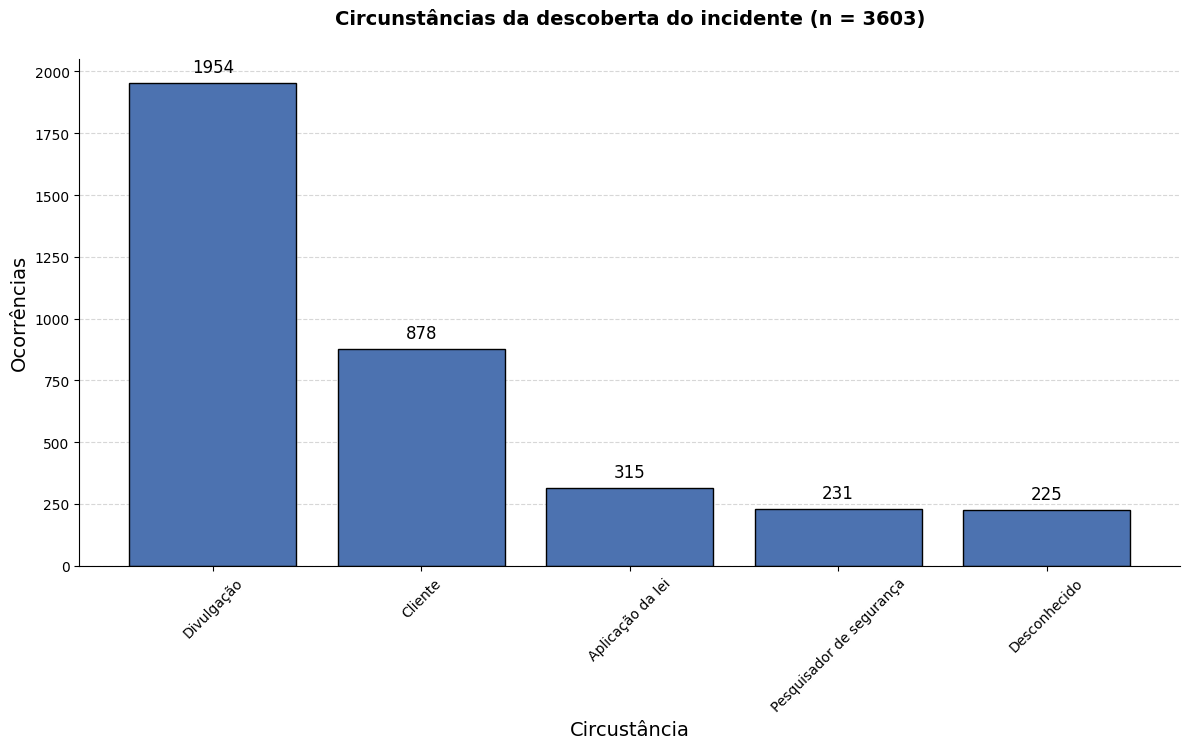

In [475]:
replace_map = {
    "Actor disclosure": "Divulgação",
    "Customer": "Cliente",
    "Law enforcement": "Aplicação da lei",
    "Security researcher": "Pesquisador de segurança",
    "Unknown": "Desconhecido"
}

data = count_categories("discovery_method.external.variety.*").replace(replace_map).set_index("category")["occurrences"].sort_values(ascending=False)[:5]

barplot(
    fig_name="discovery_methods",
    data=data,
    plot={
        "title": f"Circunstâncias da descoberta do incidente (n = {data.sum()})",
        "xlabel": "Circustância",
        "ylabel": "Ocorrências",
        "xrotation": 45,
        "figsize": (12,8)
    }
)

# Vazamentos

## Ocorrência

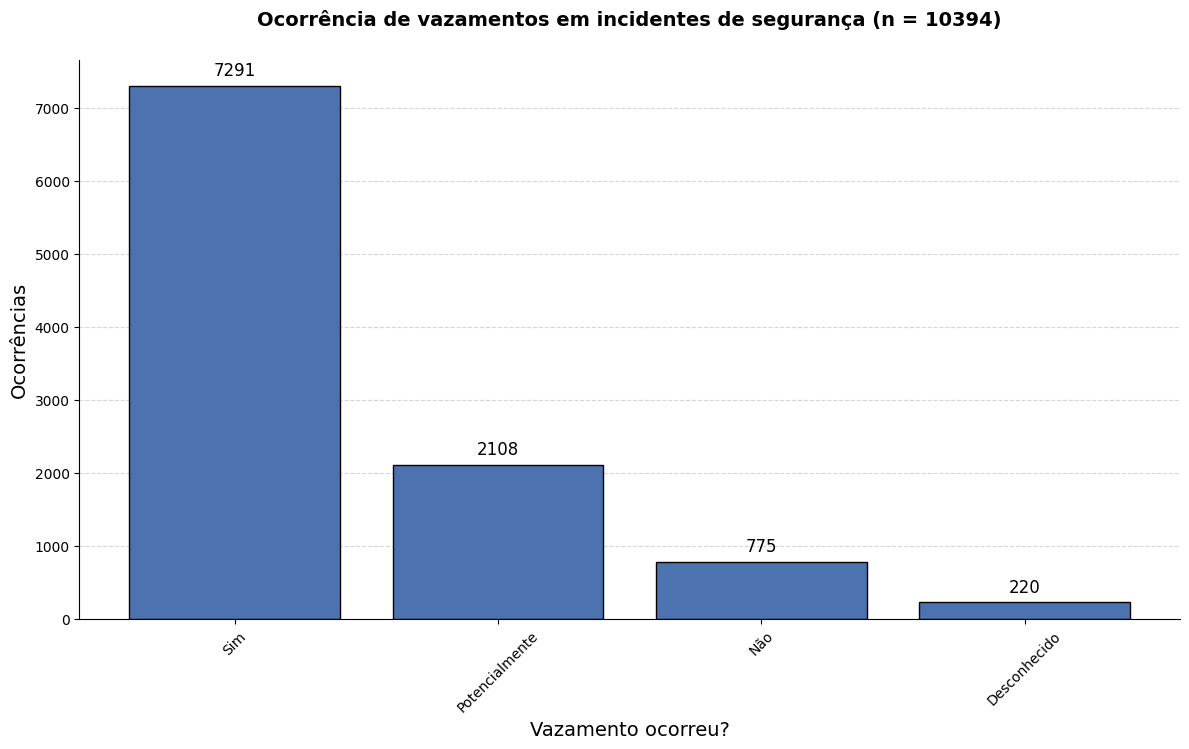

In [397]:
raw_dataframe = get_vcdb([col for col in columns if "attribute.confidentiality.data_disclosure." in col]).select_dtypes(include='bool')
breaches = raw_dataframe.sum().sort_values(ascending=False).reset_index()
breaches.columns = ["occurrence", "count"]

translate_map = {
    "Yes": "Sim",
    "Potentially": "Potencialmente",
    "No": "Não",
    "Unknown": "Desconhecido"
}
breaches["occurrence"] = breaches["occurrence"].apply(lambda x: x.split(".")[-1]).replace(translate_map)
breaches["count"].index = breaches["occurrence"]

barplot(
    fig_name="breaches_occurrence",
    data=breaches["count"].sort_values(ascending=False),
    plot={
        "title": f"Ocorrência de vazamentos em incidentes de segurança (n = {breaches["count"].sum()})",
        "xlabel": "Vazamento ocorreu?",
        "ylabel": "Ocorrências",
        "xrotation": 45,
        "figsize": (12,8)
    }
)

## Objetos-alvo

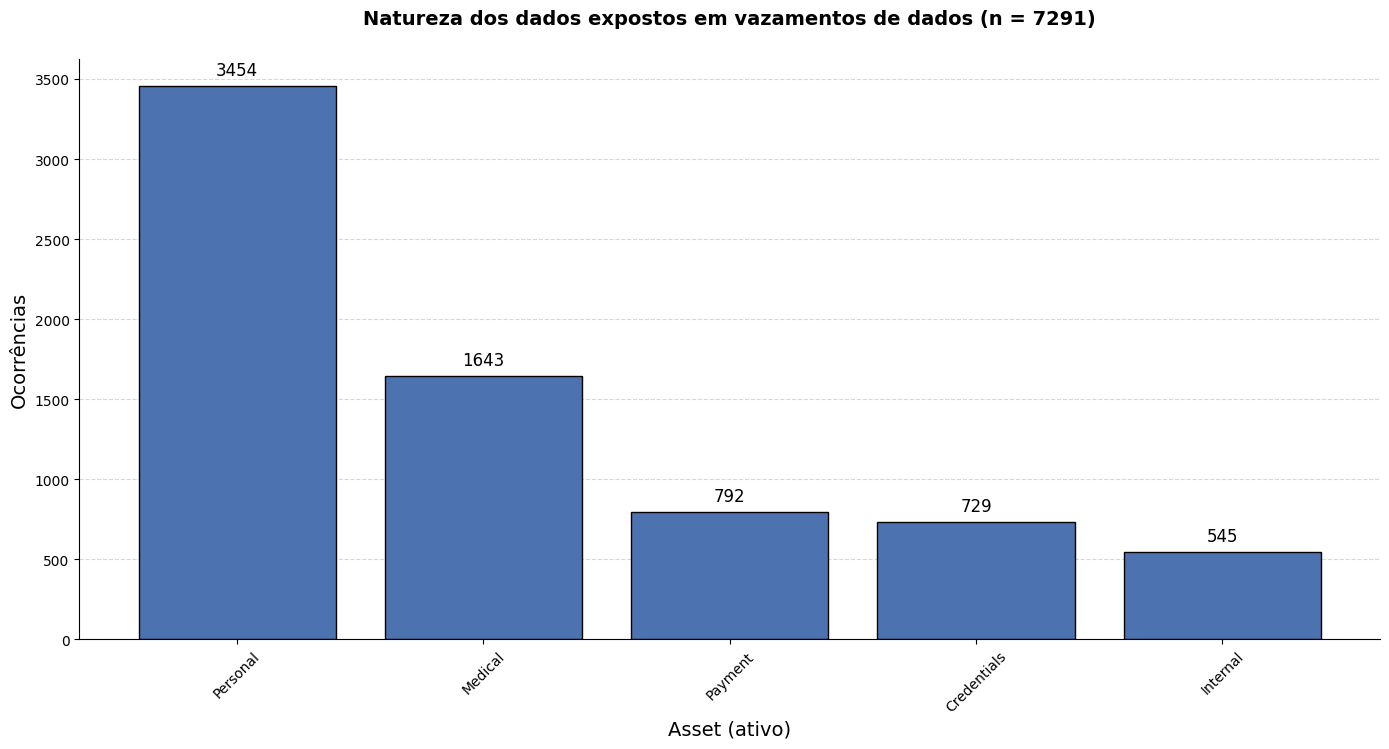

In [398]:
selected_columns = [col for col in columns if "attribute.confidentiality.data.variety." in col] + ["attribute.confidentiality.data_disclosure.Yes"]
raw_dataframe = get_vcdb(selected_columns).select_dtypes(include='bool')
raw_dataframe = raw_dataframe[raw_dataframe["attribute.confidentiality.data_disclosure.Yes"] == True]
nrows = raw_dataframe.shape[0]

target_objects = (
        raw_dataframe.drop("attribute.confidentiality.data_disclosure.Yes", axis=1)
           .sum()
           .sort_values(ascending=False)
           .reset_index()
        )

target_objects.columns = ["object", "occurrences"]
target_objects["object"] = target_objects["object"].apply(lambda x: x.split(".")[-1])
target_objects = target_objects.set_index("object")
data = target_objects[target_objects.index != "Unknown"]["occurrences"].sort_values(ascending=False)[:5]

barplot(
    fig_name="target_objects",
    data=data,
    plot={
        "title": f"Natureza dos dados expostos em vazamentos de dados (n = {nrows})",
        "xlabel": "Asset (ativo)",
        "ylabel": "Ocorrências",
        "xrotation": 45
    }
)

## Ocorrências por Ano

In [463]:
df[(df["year"] > 1900) & (df["year"] <= 2025)].value_counts()

year
2013    1817
2014    1066
2016     911
2015     749
2012     707
2020     281
2019     252
2018     203
2021     147
2017     127
2011     104
2023      69
2022      54
2008      48
2010      42
2009      34
2024      29
2007      26
2006      15
2005      10
2004       3
2002       3
2003       3
2001       2
1971       1
1984       1
1994       1
1999       1
Name: count, dtype: int64

In [467]:
data.dtypes

dtype('int64')

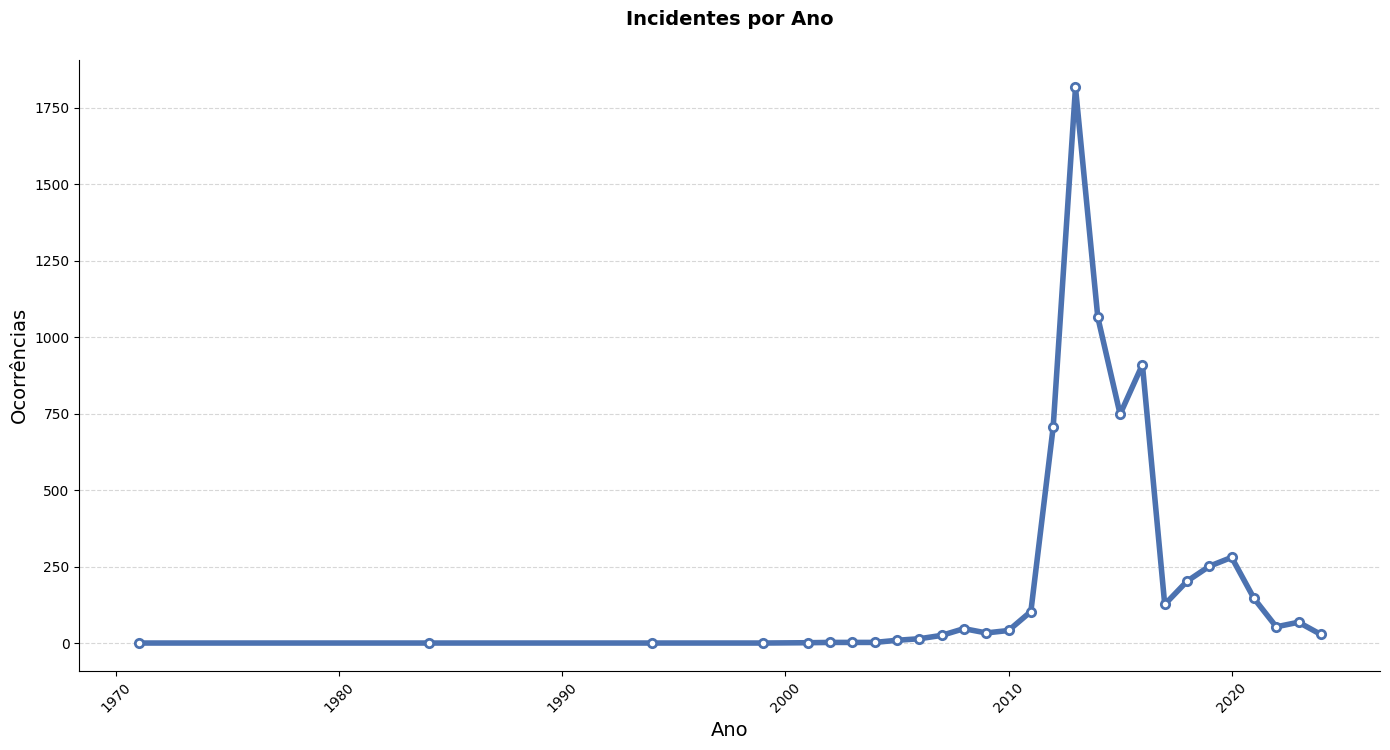

In [474]:
df = get_vcdb(["plus.timeline.notification.year"]).dropna().astype('Int64')
df.columns = ["year"]

data = df[(df["year"] > 1900) & (df["year"] <= 2025)]["year"].value_counts().sort_index(ascending=False)

# Cria figura e eixo
fig, ax = plt.subplots(figsize=(14, 8))

# Plota os dados e armazena o objeto de barras
bars = ax.plot(
    data.index,
    data.values,
    color="#4C72B0",
    marker='o',
    linewidth=4,
    markersize=6,         # aumenta o tamanho dos pontos
    markerfacecolor="white",  # deixa os marcadores com fundo branco
    markeredgewidth=2     # borda dos marcadores
)

# Adiciona título e labels
ax.set_title("Incidentes por Ano", fontsize=14, fontweight="bold", pad=25)
ax.set_xlabel("Ano", fontsize=14)
ax.set_ylabel("Ocorrências", fontsize=14)

# Adiciona os valores nas barras
# ax.bar_label(bars, fontsize=12, padding=5, fmt="%d")

# Limpa bordas
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Grelha horizontal leve
ax.yaxis.grid(True, linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

# Rotação dos rótulos do eixo X
plt.xticks(rotation=45, ha="center")

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(f"img/incidents_by_year.png", dpi=1000)